Check gpu

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  8 23:12:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check memory.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


Install dependencies

In [ ]:
!pip install tensorflow==2.5.0
!pip install tensorflow-text==2.5.0
!pip install pyrouge==0.1.3
!pip install rouge==1.0.0
!pip install transformers==2.5.1
!pip install keras_nlp 
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 454.4 MB 42 kB/s 
     |████████████████████████████████| 132 kB 74.3 MB/s 
     |████████████████████████████████| 1.2 MB 55.5 MB/s 
     |████████████████████████████████| 462 kB 69.8 MB/s 
     |████████████████████████████████| 4.0 MB 67.0 MB/s 
     |████████████████████████████████| 14.9 MB 59.9 MB/s 
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4849 sha256=0ddff1aa0d4eb74b5950f109b55a4f9500106cf207b0d8ba78e609876aeef756
  Stored in directory: /root/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-linux_x86_64.whl size=72337 sha256=84aba9d6d941510542bf47e7b101129f6cc9727d14af5c26a9cf05d014b6b2a2
  Stored in directory: /root/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 3.4 MB/s 
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191620 sha256=c2a05165b1b8a05865447ad6529349b4fc8df75c1855ace56fa46b69147d7715
  Stored in directory: /root/.cache/pip/wheels/00/85/fd/ccd28e53c9f6a691e6ea96050a0cad95f9a4a6361269d765ca
Successfully built pyrouge
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 499 kB 4.3 MB/s 
     |████████████████████████████████| 132 kB 86.1 MB/s 
     |████████████████████████████████| 880 kB 93.2 MB/s 
     |█████████████████████████

In [ ]:
# import os
# import sys

# isColab = "google.colab" in sys.modules
# # this also works: 
# # isColab = "COLAB_GPU" in os.environ

# if isColab:
#     os.environ["SDL_VIDEODRIVER"] = "dummy"
#     from google.colab import drive 
#     drive.mount("/content/drive", force_remount=True) 

#     colab_path = ('/content/drive/MyDrive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd 'drive/My Drive'

/content/drive/My Drive


In [ ]:
cd Deep-Learning-Project

/content/drive/My Drive/Deep-Learning-Project


Import the python packages required.

In [ ]:
import sys
import argparse
import os
import json
from time import time
from datetime import timedelta
from os.path import join, exists
import pdb
import tensorflow as tf
import keras_nlp

In [ ]:
tf.print(tf. __version__)

2.5.0


Import the repos required classes.

In [ ]:
from utils import read_jsonl, get_data_path, get_result_path, get_all_summaries
from dataloader import MatchSumPipe
from model import MatchSum
from metrics import MarginRankingLoss, ValidMetric, MatchRougeMetric
from callback import MyLRSchedule

Define the arguments the model will take in.

In [ ]:
params = {
          'train_samples': 10000,
          'valid_samples': 1000,
          'test_samples': 500,
          'encoder': 'distilbert',
          'candidate_num': 20,
          'batch_size': 16,
          'accum_count': 2,
          'max_lr': 2e-05,
          'margin': 0.01,
          'warmup_steps': 10000,
          'n_epochs': 25,
          'valid_steps': 1000,
          'model_name': 'cnn_model'
}

Train the model.

Load the training and validation sets.

In [ ]:
# def get_data_paths(mode, encoder):

#     #def path as dictionary
#     paths = {}

#     #for supplying data path into data folder

#     #for training: put two different keys into dict, one for train
#     #and another for validation
#     if mode == 'train':
#         paths['train'] = 'data/train_newsroom.jsonl'
#         paths['val']   = 'data/val_newsroom.jsonl'
#     else:
#         paths['test']  = 'data/test_newsroom.jsonl'
#     return paths
  
data_paths = get_data_paths('train', 'bert')


save_path = './distilbert'
for name in data_paths:
    assert exists(data_paths[name])
if not exists(save_path):
    os.makedirs(save_path)

train_cand_dataset, train_text_dataset, train_summ_dataset = MatchSumPipe(num_samples=params['train_samples']).process_from_file(data_paths['train'])
val_cand_dataset, val_text_dataset, val_summ_dataset = MatchSumPipe(num_samples=params['valid_samples']).process_from_file(data_paths['val'])

Start loading datasets !!!
Finished in 0:00:02.829842
Start loading datasets !!!
Finished in 0:00:01.174809


In [ ]:
print(train_cand_dataset.shape)
print(val_cand_dataset.shape)

(680, 20, 100)
(278, 20, 100)


In [ ]:
train_params = params
# devices, train_params = configure_training(args)
with open(join(save_path, 'params.json'), 'w') as f:
    json.dump(train_params, f, indent=4)
# print('Devices is:')
# print(devices)

Get the candidate and golden summaries for the training and validation set.

In [ ]:
train_summaries, train_candidate_summaries = get_all_summaries(data_paths['train'], num_samples=params['train_samples'])
val_summaries, val_candidate_summaries = get_all_summaries(data_paths['val'], num_samples=params['valid_samples'])

In [ ]:
print(train_summaries.shape)
print(val_summaries.shape)

(680,)
(278,)


Configure the model.

In [ ]:
model = MatchSum(params['candidate_num'], params['encoder'])
optimizer = tf.keras.optimizers.Adam(learning_rate=MyLRSchedule(0.0, max_lr=params['max_lr'], warmup_steps = params['warmup_steps'], update_every = params['accum_count'])) # Learning rate may need to be changed depending on issues

criterion = MarginRankingLoss(params['margin'])

model.compile(
    optimizer = optimizer,
    loss = criterion,
    metrics = [keras_nlp.metrics.RougeN(order=1, dtype=tf.float32, name='rouge-1'), keras_nlp.metrics.RougeN(order=2, dtype=tf.float32, name='rouge-2'), keras_nlp.metrics.RougeL(dtype=tf.float32, name='rouge-l')]
)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


Train the model.

In [ ]:
print('Start training with the following hyper-parameters:')
print(train_params)
model.fit(
    x=[train_text_dataset, train_cand_dataset, train_summ_dataset], # not sure what data structure this is
    y=[train_candidate_summaries, train_summaries],
    batch_size=params['batch_size'],
    epochs=params['n_epochs'],
    verbose=1, # Can be changed
    # callbacks=[MyCallback()],
    # validation_split=0.0,
    validation_data=([val_text_dataset, val_cand_dataset, val_summ_dataset], [val_candidate_summaries, val_summaries]),
    shuffle=False, # This could be something that is important
    # class_weight=None,
    # sample_weight=None,
    # initial_epoch=0,
    # steps_per_epoch=None,
    # validation_steps=1,
    # validation_batch_size=valid_cand_dataset.shape[0],
    # validation_freq=1,
    # max_queue_size=10,
    # workers=1,
    # use_multiprocessing=False
)

Start training with the following hyper-parameters:
{'train_samples': 10000, 'valid_samples': 1000, 'test_samples': 50, 'encoder': 'distilbert', 'candidate_num': 20, 'batch_size': 16, 'accum_count': 2, 'max_lr': 2e-05, 'margin': 0.01, 'warmup_steps': 10000, 'n_epochs': 25, 'valid_steps': 1000, 'model_name': 'cnn_model'}
Epoch 1/25


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


43/43 [==============================] - 54s 656ms/step - loss: 1.9155 - val_loss: 1.9219 - val_averaged rouge f1_scores: 0.1186
Epoch 2/25
43/43 [==============================] - 25s 595ms/step - loss: 1.9159 - val_loss: 1.9142 - val_averaged rouge f1_scores: 0.1278
Epoch 3/25
43/43 [==============================] - 25s 595ms/step - loss: 1.9186 - val_loss: 1.9140 - val_averaged rouge f1_scores: 0.1224
Epoch 4/25
43/43 [==============================] - 25s 594ms/step - loss: 1.9111 - val_loss: 1.9122 - val_averaged rouge f1_scores: 0.1277
Epoch 5/25
43/43 [==============================] - 25s 595ms/step - loss: 1.9147 - val_loss: 1.9179 - val_averaged rouge f1_scores: 0.1308
Epoch 6/25
43/43 [==============================] - 25s 595ms/step - loss: 1.9189 - val_loss: 1.9222 - val_averaged rouge f1_scores: 0.1227
Epoch 7/25
43/43 [==============================] - 25s 594ms/step - loss: 1.9191 - val_loss: 1.9149 - val_averaged rouge f1_scores: 0.1299
Epoch 8/25
43/43 [=============

Save trained model.

In [ ]:
#save the model you just created
# model.save('./models/{}'.format(params['model_name']))

Evaluate the model.

In [ ]:
from re import I
# load dataset
# test_data_paths = get_data_path('test', 'bert')

test_data_paths = get_data_paths('test', 'bert')

test_cand_dataset, test_text_dataset, test_summ_dataset = MatchSumPipe(num_samples=params['test_samples']).process_from_file(test_data_paths['test'])
test_summaries, test_candidate_summaries = get_all_summaries(test_data_paths['test'], num_samples=params['test_samples'])

# dec_path, ref_path = get_result_path(save_path, "model_folder")

#reload the model for evaluation
# model = tf.keras.models.load_model('./models/{}.h5'.format(params['model_name']))

best_candidate_summaries = model.get_best_summaries(test_cand_dataset, test_text_dataset, test_candidate_summaries)

rouge_1 = keras_nlp.metrics.RougeN(order=1, dtype=tf.float32, name='rouge-1')
rouge_2 = keras_nlp.metrics.RougeN(order=2, dtype=tf.float32, name='rouge-2')
rouge_l = keras_nlp.metrics.RougeL(dtype=tf.float32, name='rouge-l')

for i, j in zip(best_candidate_summaries, test_summaries):
    tf.print("best candidate summary:")
    tf.print(i)
    tf.print("golden summary:")
    tf.print(j)
    tf.print("rouge_1:")
    tf.print(rouge_1(j, i)['f1_score'])
    tf.print("rouge_2:")
    tf.print(rouge_2(j, i)['f1_score'])
    tf.print("rouge_l:")
    tf.print(rouge_l(j, i)['f1_score'])
    tf.print("combined rouge average:")
    tf.print((rouge_1(j, i)['f1_score'] + rouge_2(j, i)['f1_score'] + rouge_l(j, i)['f1_score']) / 3.0)
    tf.print()

Start loading datasets !!!
Finished in 0:00:00.433051


INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


best candidate summary:
I've been shot!" "The girl was covered with blood," he remembered. "
golden summary:
Bleeding from a massive chest wound, Tejano star Selena cried, "Help me! I've been shot!"and then named her killer with her dying breath. Shaken witnesses yesterday told a spellbound Houston courtroom how the blood-covered, mortally wounded 23-year-old Hispanic singing sensation burst into the lobby of the Corpus Christi Days Inn last March 31. Gasping for breath, Selena told motel workers that Yolanda Saldivar the president of her fan club shot
rouge_1:
0.183908045
rouge_2:
0.0705882385
rouge_l:
0.137931034
combined rouge average:
0.130809113

best candidate summary:
She said results will be shared with doctors in the United States, "so everyone will be on the same page." She landed in Christchurch on Monday.
golden summary:
By HOLLY RAMER, Associated Press CONCORD, N.H. -- A sick American engineer who was successfully evacuated from the South Pole to New Zealand is awaiting th

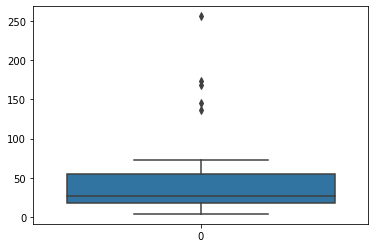

In [ ]:
import seaborn as sns
result_b = []

for i in test_summaries:
    result_b.append(len(i.numpy().split()))

sns.boxplot(data=result_b)